# Fitting Lines with the Hough Transform

In [1]:
import skimage.feature
import skimage.transform.hough_transform as ht
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

## Generate a synthetic image with a few aligned points

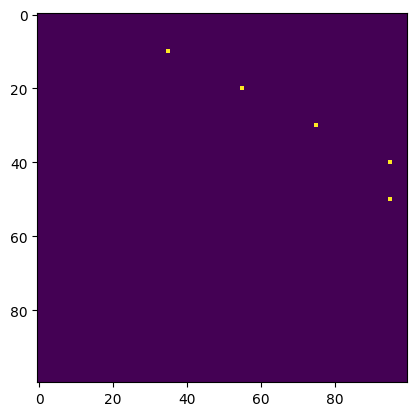

In [2]:
im = np.zeros((100,100))
im[10,35] = 1
im[20,55] = 1
im[30,75] = 1
im[40,95] = 1
im[50,95] = 1

imedges = im
plt.imshow(imedges)

## Apply the hough transform on the edge image

The [hough_line](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.hough_line) function implements the hough transform on a binary input image.  Read the documentation!

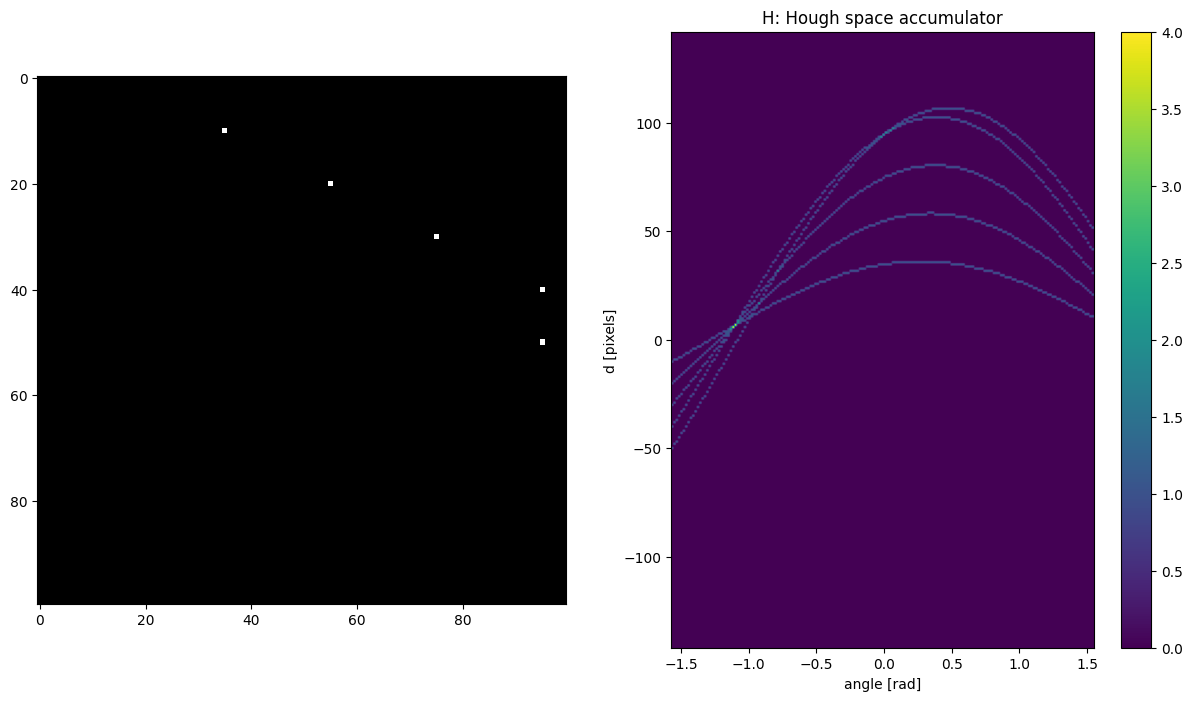

In [3]:
H,angles,distances = ht.hough_line(imedges)

fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
ax0.imshow(imedges, cmap="gray")
Himage = ax1.imshow(H,
                    extent=(angles[0],angles[-1],distances[0],distances[-1]),
                    origin="lower", aspect="auto")
ax1.set(xlabel="angle [rad]",
        ylabel="d [pixels]",
        title="H: Hough space accumulator");
plt.colorbar(Himage)

## Find the line with the most votes.

Note: [`np.argmax`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) will return a *flat index* into the 2D array `H`.  Instead, we prefer a row and column index: a flat index is converted to row, column indices with [`np.unravel_index`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unravel_index.html#numpy.unravel_index).  See below for a simple example.

In [4]:
# parenthesis: how to find the row,column of the maximum of a 2D array
A = np.array([[1, 2, 3],[4, 1, 2]])
print(A)
maxix = np.argmax(A)
print(maxix)
maxr,maxc = np.unravel_index(maxix, A.shape)
print(maxr,maxc)

[[1 2 3]
 [4 1 2]]
3
1 0


In [5]:
(maxr, maxc) = np.unravel_index(np.argmax(H), H.shape)
d = distances[maxr]
theta = angles[maxc]
print(d,theta)

6.0 -1.117010721276371


## Visualize the line with the most votes

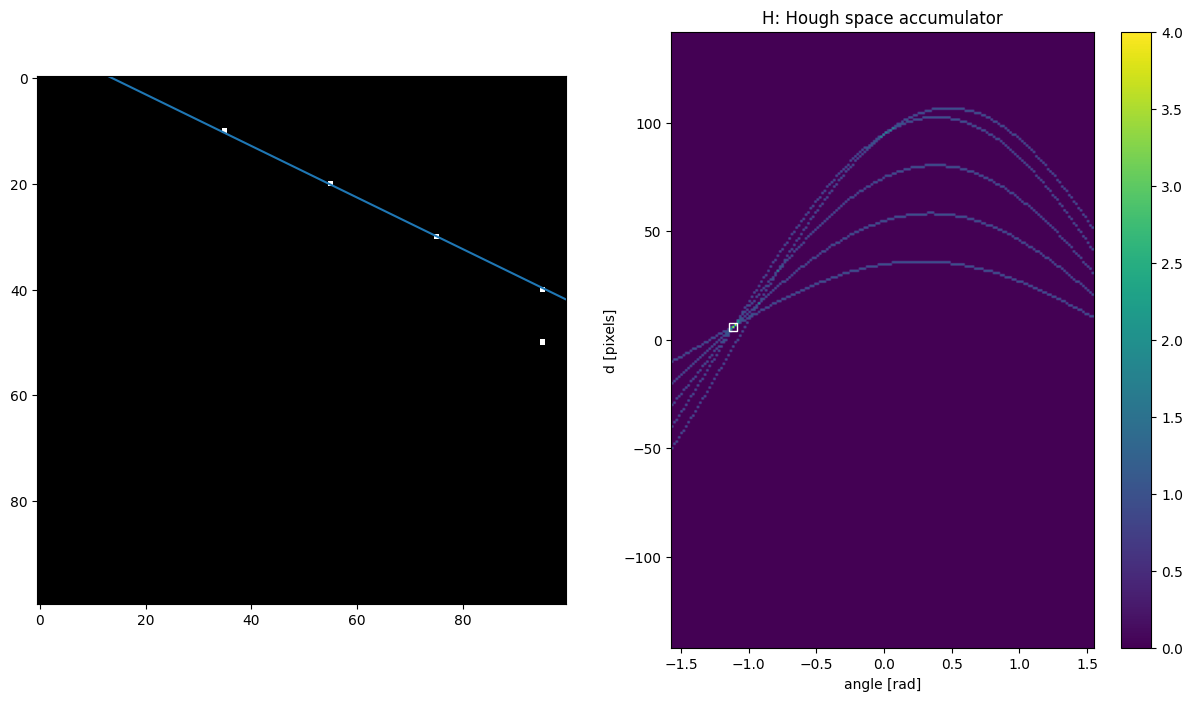

In [6]:
# Same figure as before...
fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
ax0.imshow(imedges, cmap="gray")
Himage = ax1.imshow(H,extent=(angles[0],angles[-1],distances[0],distances[-1]),origin="lower",aspect="auto")
ax1.set(xlabel="angle [rad]",
        ylabel="d [pixels]",
        title="H: Hough space accumulator");
plt.colorbar(Himage)

# Plot a white rectangle over the maximum
ax1.plot(theta, d, "ws", fillstyle="none")

## Now we want to draw the line in image space
# This is one point on the line
p1 = np.array([d*np.cos(theta), d*np.sin(theta)])
# This is the unit vector pointing in the direction of the line (remember what theta means in Hough space!)
linedir = np.array([np.cos(theta+np.pi/2), np.sin(theta+np.pi/2)])
# These are two points very far away in two opposite directions along the line
p0 = p1 - linedir * 1000
p2 = p1 + linedir * 1000
# We now draw a line through p0 and p2, without rescaling the axes.
ax0.plot([p0[0],p2[0]],[p0[1],p2[1]], scalex=False, scaley=False)

Now, zoom in the hough space nearby the line with most votes

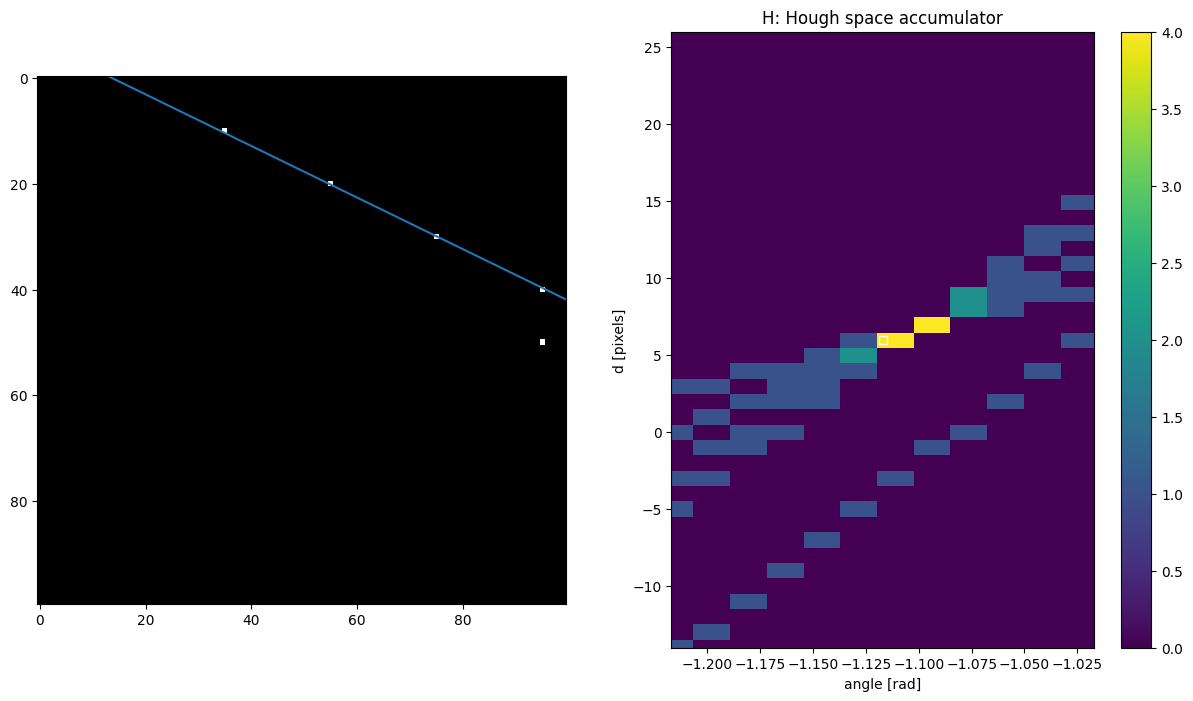

In [7]:
ax1.set(xlim = [theta - 0.1, theta + 0.1],
        ylim = [d - 20, d + 20])
fig

## Let's now try on a real image

In [8]:
import skimage.data
import skimage.feature

im = skimage.data.camera()
imedges = skimage.feature.canny(im)

... now run the cells above again!

## Finding segments
The [`probabilistic_hough_line`](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.probabilistic_hough_line) function is an higher-level function that returns *line segments*.  Read the documentation to learn about its parameters.

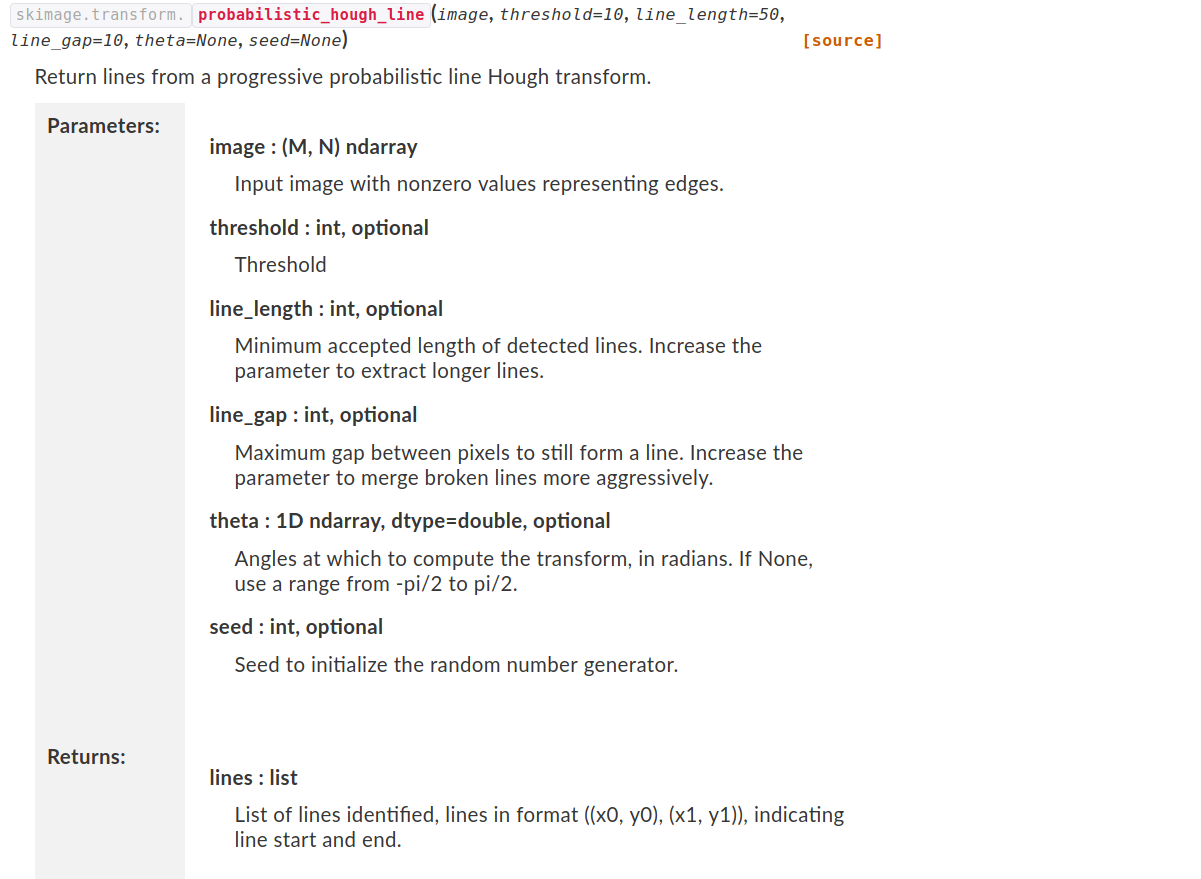

In [9]:
lines = ht.probabilistic_hough_line(imedges,
                                    threshold=100)
len(lines)

357

## Draw the detected segments over the original image

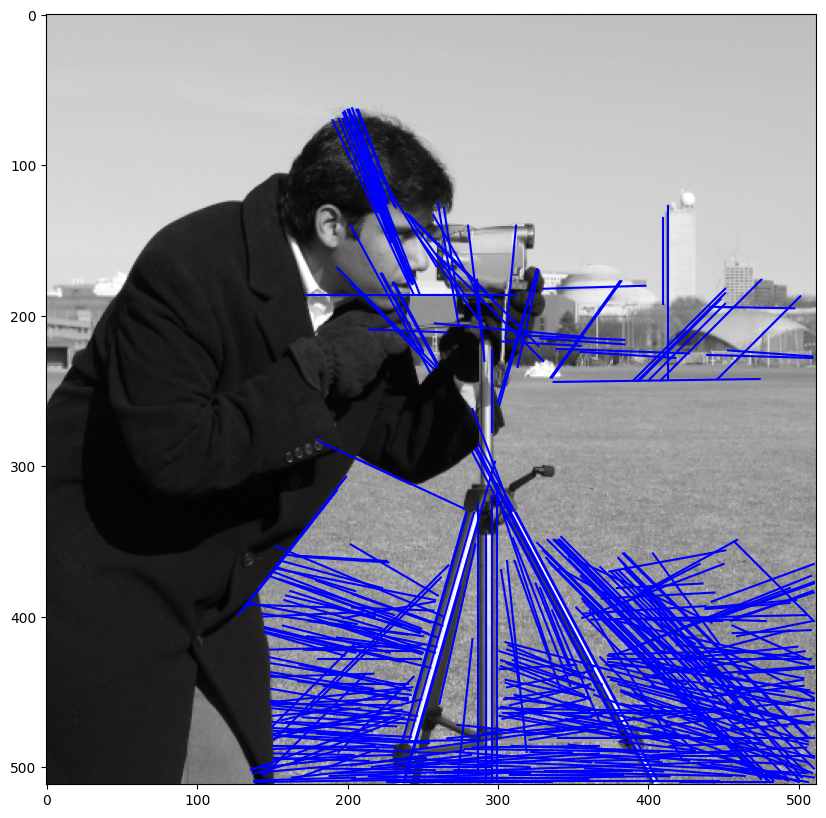

In [10]:
fig,ax = plt.subplots(figsize=(10,10))

ax.imshow(im,cmap="gray")
for ((x0,y0),(x1,y1)) in lines:
    ax.plot([x0,x1],[y0,y1],'b-')

Look at all the clutter on the bottom!

Let's tweak the Canny sigma parameter to get rid of it.

In [11]:
@widgets.interact(canny_sigma=(1,10), hough_threshold=(10,200,20))
def f(canny_sigma, hough_threshold):
    imedges = skimage.feature.canny(im, sigma=canny_sigma)
    lines = ht.probabilistic_hough_line(imedges,
                                        threshold=hough_threshold,
                                        seed=0)
    fig,(ax0,ax1) = plt.subplots(ncols=2, figsize=(12,8))
    ax0.imshow(im,cmap="gray")
    for ((x0,y0),(x1,y1)) in lines:
        ax0.plot([x0,x1],[y0,y1],'b-')
    ax1.imshow(imedges,cmap="gray")

interactive(children=(IntSlider(value=5, description='canny_sigma', max=10, min=1), IntSlider(value=90, descri…

## Exercise
Look at the tower in the background.  It is hard to detect using the code above unless sigma is very small. Can you guess why?

Which other parameters does our code have that affect its behavior?  How would you change these parameters in order to make the hough algorithm capable of detecting the vertical lines at the side of the tower, without detecting all the clutter in the grass at the bottom?

### Solution hint 1
Yes it is possible, by only acting on the canny `sigma`, `low_threshold`, `high_threshold` parameters in addition to the hough segment `threshold` parameter.  Look at a possible result, obtained for some value of these parameters. Can you infer how?
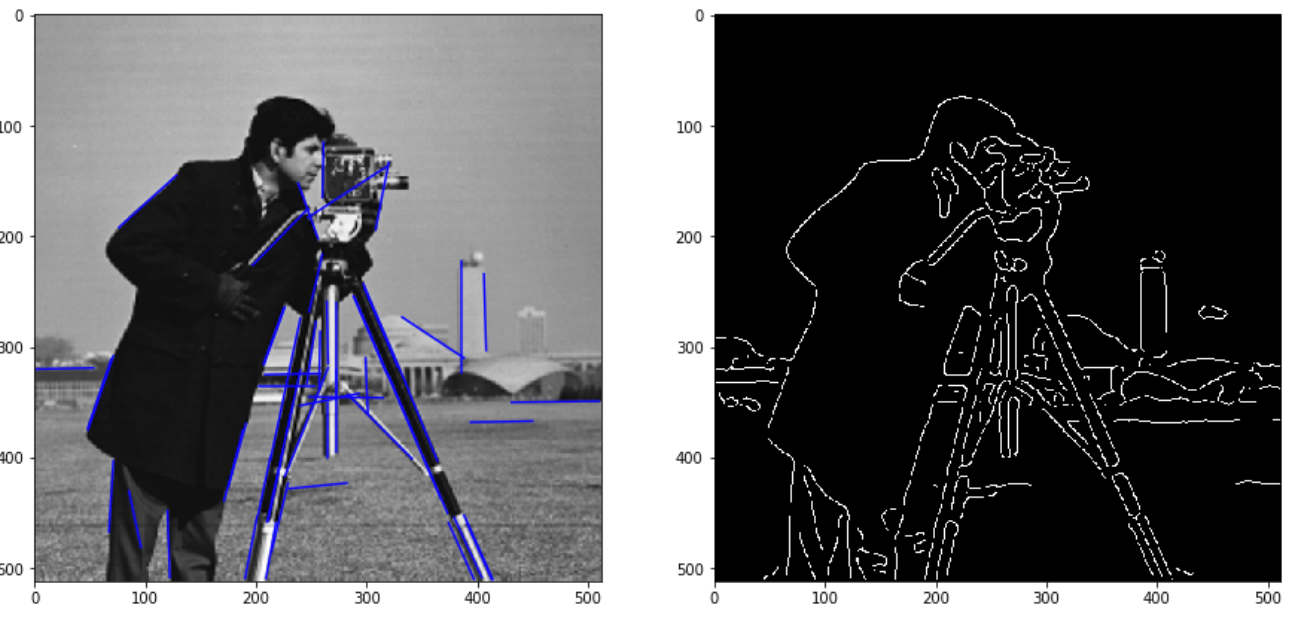

### Solution hint 2
The tower does not have a lot of contrast with the background, but it is a relatively large object and it does not have a fine texture like the grass. So we expect that by setting a large sigma for canny, the tower gradients should "survive" whereas the fine details of the grass should be canceled out.  Then we need very low canny thresholds in order to be able to see the tower, but it turns out that is enough.

### Actual solution
The solution above is obtained with
- `canny_sigma = 4.00`
- `canny_low_threshold = 0.00`
- `canny_high_threshold = 0.10`
- `hough_threshold = 30`

Experiment with the code below

In [12]:
# Solution
@widgets.interact(canny_sigma=(0.0,6.0,0.1),
                  canny_low_threshold=(0.00,0.4,0.01),
                  canny_high_threshold=(0.00,0.4,0.01),
                  hough_threshold=(10,200,20))
def f(canny_sigma, canny_low_threshold, canny_high_threshold, hough_threshold):
    imedges = skimage.feature.canny(skimage.img_as_float(im),
                                    low_threshold=canny_low_threshold,
                                    high_threshold=canny_high_threshold,
                                    sigma=canny_sigma)
    lines = ht.probabilistic_hough_line(imedges,
                                        threshold=hough_threshold,
                                        seed=0)
    fig,(ax0,ax1) = plt.subplots(ncols=2, figsize=(15,8))
    ax0.imshow(im,cmap="gray")
    for ((x0,y0),(x1,y1)) in lines:
        ax0.plot([x0,x1],[y0,y1],'b-')
    ax1.imshow(imedges,cmap="gray")


interactive(children=(FloatSlider(value=3.0, description='canny_sigma', max=6.0), FloatSlider(value=0.2, descr…

## Exercise

Assume that we are interested in finding only lines that have exactly a given direction in the image space.  Using the `hough_line` function (not the `probabilistic_hough_line` function!), modify the code we wrote above in order to find the most prominent line which has a given orientation $\pm 10$ degrees.

Hint: compute the hough transform as usual. Then, instead of looking for the maximum over the whole matrix...

**Extension**: draw the *three* most prominent lines with the requested orientation

In [13]:
# Solution
imedges = skimage.feature.canny(im)
H,angles,distances = ht.hough_line(imedges)
@widgets.interact(desired_angle=(-80,80,1))
def f(desired_angle):
    
    # Remove all votes for lines that do not have a compatible angle with the one we are looking for
    H_filtered = H.copy()
    angles_compatible = ((angles > np.deg2rad(desired_angle-10)) &
                         (angles < np.deg2rad(desired_angle+10)))
    H_filtered[:,~angles_compatible] = 0
    
    (maxr, maxc) = np.unravel_index(np.argmax(H_filtered), H_filtered.shape)
    d = distances[maxr]
    theta = angles[maxc]

    fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
    ax0.imshow(im, cmap="gray")
    Himage = ax1.imshow(H_filtered,extent=(angles[0],angles[-1],distances[0],distances[-1]),origin="lower",aspect="auto")
    ax1.set(xlabel="angle [rad]",
            ylabel="d [pixels]",
            title="H: Hough space accumulator");
    plt.colorbar(Himage)

    # Plot a white rectangle over the maximum
    ax1.plot(theta, d, "ws", fillstyle="none")

    ## Now we want to draw the line in image space
    # This is one point on the line
    p1 = np.array([d*np.cos(theta), d*np.sin(theta)])
    # This is the unit vector pointing in the direction of the line (remember what theta means in Hough space!)
    linedir = np.array([np.cos(theta+np.pi/2), np.sin(theta+np.pi/2)])
    # These are two points very far away in two opposite directions along the line
    p0 = p1 - linedir * 1000
    p2 = p1 + linedir * 1000
    # We now draw a line through p0 and p2, without rescaling the axes.
    ax0.plot([p0[0],p2[0]],[p0[1],p2[1]], scalex=False, scaley=False)
    ax0.set_title(f"Displaying the most prominent line with angle {desired_angle} ±10 degrees")

interactive(children=(IntSlider(value=0, description='desired_angle', max=80, min=-80), Output()), _dom_classe…

To solve the extension, you need to find the row and column indices of the largest 3 elements of a matrix. It works like this:

In [14]:
a = np.array([[4,6,8],[1,9,2]])
print(a)
sortedrows,sortedcols = np.unravel_index(np.argsort(a, axis=None), a.shape)
max3rows = sortedrows[:-4:-1]
max3cols = sortedcols[:-4:-1]
print("3 largest elements:")
for r,c in zip(max3rows,max3cols):
    print(f"r,c={r,c} value={a[r,c]}")

[[4 6 8]
 [1 9 2]]
3 largest elements:
r,c=(np.int64(1), np.int64(1)) value=9
r,c=(np.int64(0), np.int64(2)) value=8
r,c=(np.int64(0), np.int64(1)) value=6


# Fitting circles with the hough transform
We will use the function [`hough_circle`](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.hough_circle)
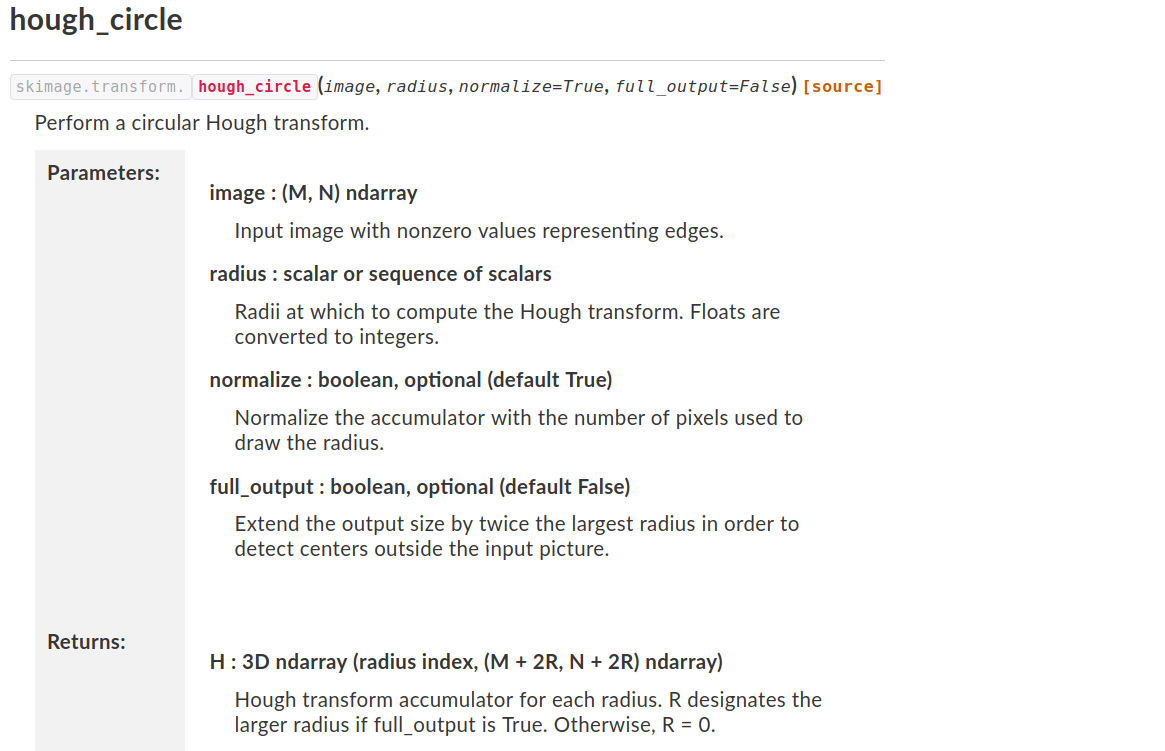

## Apply the transformation to a synthetic image with a few white pixels, for a single radius

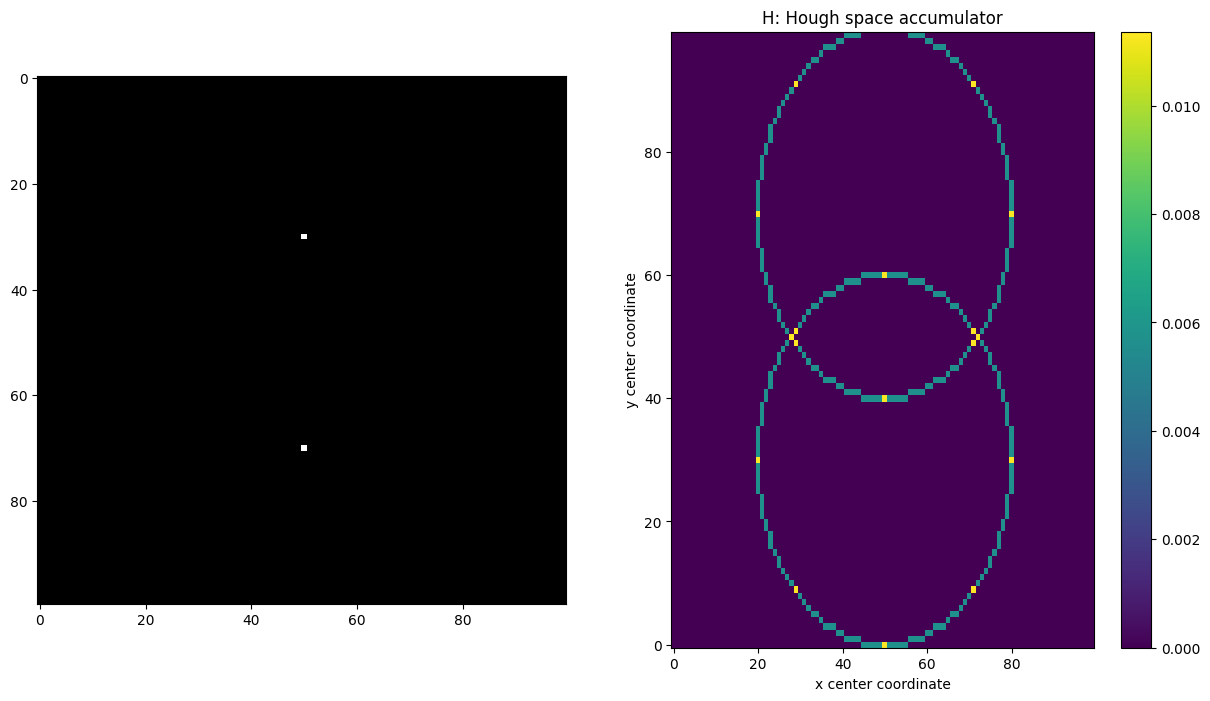

In [15]:
im = np.zeros((100, 100))
im[30,50] = 1
im[70,50] = 1

imedges = im

radius = 30
H = ht.hough_circle(im, [radius])
ridx, r, c = np.unravel_index(np.argmax(H), H.shape)

fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
ax0.imshow(imedges, cmap="gray")
Himage = ax1.imshow(H[0,:,:],origin="lower",aspect="auto")
plt.colorbar(Himage)
ax1.set(xlabel="x center coordinate",
        ylabel="y center coordinate",
        title="H: Hough space accumulator");

## Apply the transformation to look for circles with different radii
Load the `coins` image and find its edges

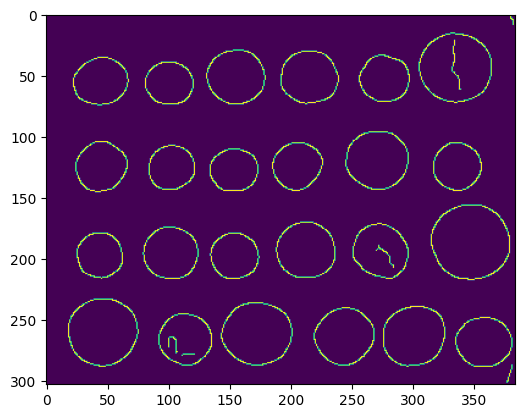

In [16]:
im = skimage.data.coins()
imedges = skimage.feature.canny(im, sigma=3)
plt.imshow(imedges)

Now look for circles with radii in a range between 15 and 35 pixels.

Note that the `H` accumulator is now 3D, and the first dimension is the index of the radius.

In [17]:
radii = np.arange(15,35)
H = ht.hough_circle(imedges, radii)
maxvotes = np.max(H)
#ridx, r, c = np.unravel_index(np.argmax(H), res.shape)

@widgets.interact(radius_ix=(0,len(radii)-1))
def f(radius_ix):
    fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
    ax0.imshow(im, cmap="gray")
    Himage = ax1.imshow(H[radius_ix,:,:],
                        vmax=maxvotes)
    ax1.set(xlabel="x center coordinate",
            ylabel="y center coordinate",
            title=f"H: Hough space accumulator for radius {radii[radius_ix]}");
    plt.colorbar(Himage)

interactive(children=(IntSlider(value=9, description='radius_ix', max=19), Output()), _dom_classes=('widget-in…

In order to find peaks in the transform, we use [`hough_circle_peaks`](http://scikit-image.org/docs/dev/api/skimage.transform.html#hough-circle-peaks)

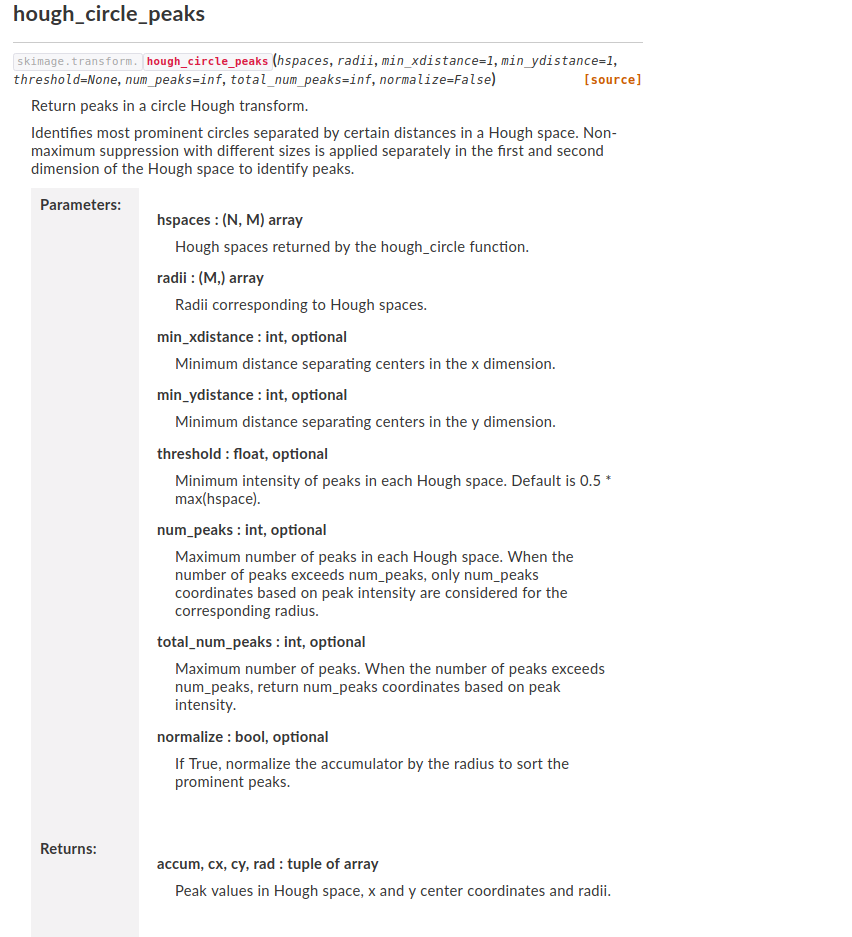

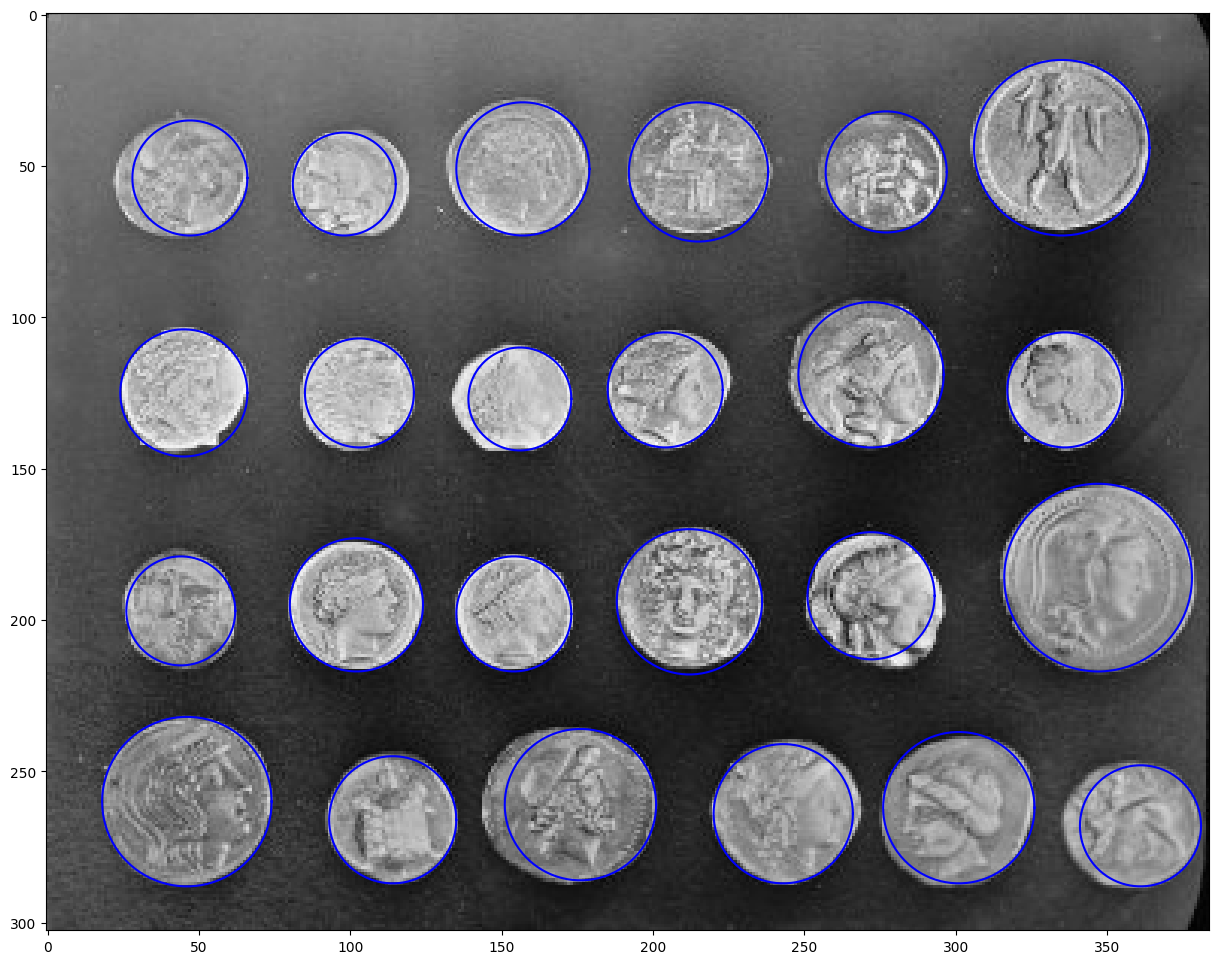

In [18]:
accums, cxs, cys, rads = ht.hough_circle_peaks(
    hspaces=H, radii=radii, threshold=0.4,
    min_xdistance=15, min_ydistance=15)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(im, cmap="gray")
for accum, cx, cy, rad in zip(accums, cxs, cys, rads):
    t = np.linspace(0,2*np.pi,181)
    ax.plot(cx+np.cos(t)*rad, cy+np.sin(t)*rad, "b-")

## Exercise
Write a function that processes one image and finds circles in that image, using `hough_circle` and `hough_circle_peaks`.

The code below reads 5 images containing balls from wikimedia, resizes them and converts them to grayscale.
Finetune the parameters of your function in order to have a good performance on these 5 images.  Of course it will not be possible to find all balls in all images!

Then, go to this [link](https://commons.wikimedia.org/wiki/Category:Balls), find 5 new images you like containing balls, apply the same code to download them.
Look at the resulting images and try to predict which balls your function will be able to find and which it won't.  Then run it without changing its parameters: did you expect the results?

Reading https://upload.wikimedia.org/wikipedia/commons/1/13/%22Balun%22.jpg
Reading https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/A_la_mar..por_pelotas_-_panoramio.jpg/640px-A_la_mar..por_pelotas_-_panoramio.jpg
Reading https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Apricot_floorball_ball.jpg/640px-Apricot_floorball_ball.jpg
Reading https://upload.wikimedia.org/wikipedia/commons/c/cc/Aston_panters.jpg
Reading https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Brasilia_DF_Brasil_-_Planta%C3%A7%C3%A3o_de_Bola_na_P%C3%A7a._dos_Tres_Poderes_-_panoramio.jpg/640px-Brasilia_DF_Brasil_-_Planta%C3%A7%C3%A3o_de_Bola_na_P%C3%A7a._dos_Tres_Poderes_-_panoramio.jpg


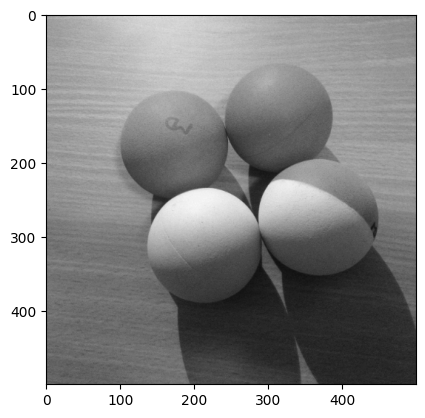

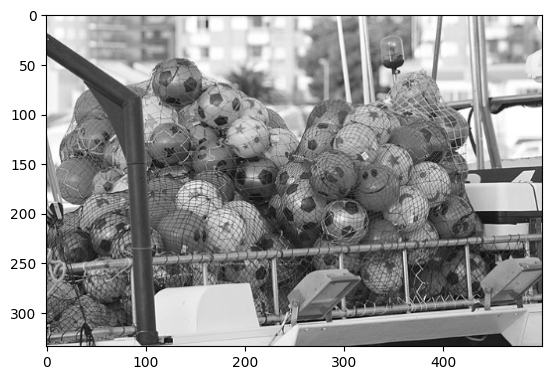

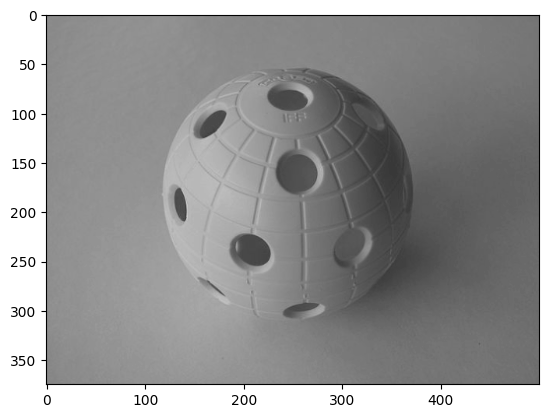

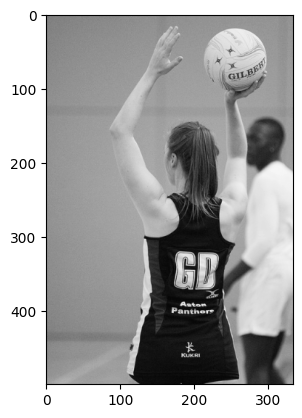

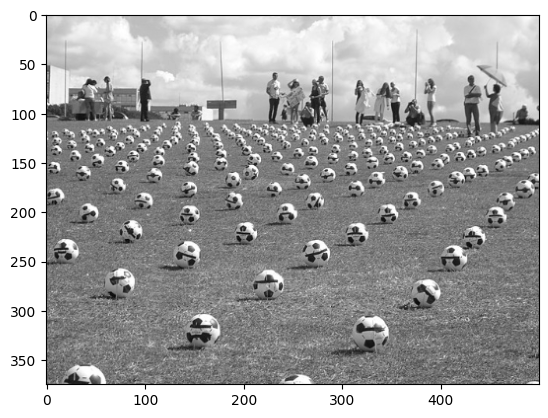

In [19]:
imageurls = ["https://upload.wikimedia.org/wikipedia/commons/1/13/%22Balun%22.jpg",
          "https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/A_la_mar..por_pelotas_-_panoramio.jpg/640px-A_la_mar..por_pelotas_-_panoramio.jpg",
          "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Apricot_floorball_ball.jpg/640px-Apricot_floorball_ball.jpg",
          "https://upload.wikimedia.org/wikipedia/commons/c/cc/Aston_panters.jpg",
          "https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Brasilia_DF_Brasil_-_Planta%C3%A7%C3%A3o_de_Bola_na_P%C3%A7a._dos_Tres_Poderes_-_panoramio.jpg/640px-Brasilia_DF_Brasil_-_Planta%C3%A7%C3%A3o_de_Bola_na_P%C3%A7a._dos_Tres_Poderes_-_panoramio.jpg"]

images = []
for imageurl in imageurls:
    print(f"Reading {imageurl}")
    im = skimage.io.imread(imageurl)
    img = skimage.color.rgb2gray(im)
    factor = 500 / max(img.shape) # reduce size such that largest dimension is 500px
    imgs = skimage.transform.rescale(img, scale=factor)
    images.append(imgs)
    

for image in images:
    fig,ax = plt.subplots()
    ax.imshow(image, cmap="gray", vmin=0, vmax=1)

In [20]:
def findcircles(imedges):
    radii = np.arange(20,100,2)
    H = ht.hough_circle(imedges, radii)
    accums, cxs, cys, rads = ht.hough_circle_peaks(
        hspaces=H, radii=radii, threshold=0.4,
        min_xdistance=15, min_ydistance=15)
    return cxs, cys, rads
    
@widgets.interact(ix=(0,len(images)-1), sigma=(0.0,5,0.1))
def f(ix, sigma):
    im = images[ix]
    im = skimage.img_as_float(im)
    imedges = skimage.feature.canny(im, sigma=sigma)
    
    fig,ax = plt.subplots(figsize=(15,8))
    ax.imshow(im, cmap="gray")
    
    cxs, cys, rads = findcircles(imedges)
    for cx, cy, rad in zip(cxs, cys, rads):
        t = np.linspace(0,2*np.pi,181)
        ax.plot(cx+np.cos(t)*rad, cy+np.sin(t)*rad, "b-")

interactive(children=(IntSlider(value=2, description='ix', max=4), FloatSlider(value=2.5, description='sigma',…